In [ ]:
from drone_detector.utils import * 
from drone_detector.imports import *
import rasterio.mask as rio_mask
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
from src.tree_functions import *

The following shows how we compared the field-measured data from both study sites and annotations that are located within these plots.

## Hiidenportti

Read data and do some wrangling.

In [ ]:
field_data_path = Path('../data/hiidenportti')
anns = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')
plot_circles = gpd.read_file(field_data_path/'plot_circles.geojson')
field_data = pd.read_csv(field_data_path/'all_plot_data.csv')
virtual_plot_grid = gpd.read_file(field_data_path/'envelopes_with_trees.geojson')
conservation_areas = gpd.read_file('../data/common/LsAlueValtio.shp')
cons_hp = conservation_areas[conservation_areas.geometry.intersects(box(*anns.total_bounds))]
cons_hp = gpd.clip(cons_hp, virtual_plot_grid)

Filter plot circles so that only those present in scenes remain.

In [ ]:
plot_circles['in_vplot'] = plot_circles.apply(lambda row: 1 if any(virtual_plot_grid.geometry.contains(row.geometry)) 
                                              else 0, axis=1)
plot_circles['id'] = plot_circles['id'].astype(int)
field_data = field_data[field_data.id.isin(plot_circles[plot_circles.in_vplot==1].id.unique())]
field_data.rename(columns= {c: c.replace('.','_') for c in field_data.columns}, inplace=True)
dw_cols = ['id'] + [c for c in field_data.columns if 'dw' in c]
plot_dw_data = field_data[dw_cols].copy()
plot_circles = plot_circles[plot_circles.in_vplot == 1]

Read individual tree measurements.

In [ ]:
tree_data = pd.read_csv(field_data_path/'hp_tree_data_fixed_1512.csv')
tree_data = tree_data[tree_data.plot_id.isin(plot_dw_data.id.unique())]

Count the number of deadwood (`n_dw`), fallen deadwood (`n_ddw`) and standing deadwood (`n_udw`) from the individual field data measurements.

In [ ]:
plot_dw_data['n_dw_plot'] = plot_dw_data.id.apply(lambda row: len(tree_data[tree_data.plot_id == row]))
plot_dw_data['n_ddw_plot'] = plot_dw_data.id.apply(lambda row: len(tree_data[(tree_data.plot_id == row) 
                                                                             & (tree_data.tree_class == 4)]))
plot_dw_data['n_udw_plot'] = plot_dw_data.id.apply(lambda row: len(tree_data[(tree_data.plot_id == row) 
                                                                             & (tree_data.tree_class == 3)]))

In [ ]:
def match_circular_plot(row, plots):
    "Match annotations with field plots"
    for p in plots.itertuples():
        if row.geometry.intersects(p.geometry):
            return int(p.id)

In [ ]:
anns['plot_id'] = anns.apply(lambda row: match_circular_plot(row, plot_circles), axis=1)
anns_in_plots = anns[anns.geometry.intersects(plot_circles.geometry.unary_union)].copy()
anns_in_plots['plot_id'] = anns_in_plots.plot_id.astype(int)

Count the number of annotated deadwood instances in each circular field plot, as well as note which of the circular plots are located in the conserved areas.

In [ ]:
plot_dw_data['n_dw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots.plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots.plot_id.unique() else 0, axis=1)
plot_dw_data['n_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==2].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==2].plot_id.unique() else 0, axis=1)
plot_dw_data['n_udw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[anns_in_plots.groundwood==1].plot_id.value_counts()[row.id] 
                                              if row.id in anns_in_plots[anns_in_plots.groundwood==1].plot_id.unique() else 0, axis=1)
plot_dw_data['geometry'] = plot_dw_data.apply(lambda row: plot_circles[plot_circles.id == row.id].geometry.iloc[0], 
                                              axis=1)
plot_dw_data = gpd.GeoDataFrame(plot_dw_data, crs=plot_circles.crs)
plot_dw_data['conservation'] = plot_dw_data.apply(lambda row: 1 if any(cons_hp.geometry.contains(row.geometry))
                                                  else 0, axis=1)

Add information about conservation area to tree data.

In [ ]:
tree_data['conservation'] = tree_data.apply(lambda row: plot_dw_data[plot_dw_data.id == row.plot_id].conservation.unique()[0], axis=1)

Plot the numbers. These show that we were able to annotate slighly less deadwood than what was measured in the field. On the other hand, especially in managed forests there were also several cases where there were more fallen deadwood annotations than field measured fallen deadwood. As the resolution of our data makes it impossible to accurately tell whether a fallen trunk had DBH less than 100mm, some of the annotations can be such that were determined too thin in the field. Other likely reason is that canopy obscured the deadwood instances, as the average canopy cover percentage was around 61 % for the field plots.

In [ ]:
plot_dw_data.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 'n_ddw_ann', 'n_udw_ann'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_udw_ann,n_udw_plot
conservation,,,,
0,248,217,49,75
1,48,96,10,24
All,296,313,59,99


Get plot-wise canopy cover percentage based on LiDAR derived canopy height model as the percentage of plot area with height more than 2 meters.

In [ ]:
pcts = []

with rio.open('../../data/raw/hiidenportti/full_mosaics/CHM_Hiidenportti_epsg.tif') as src:
    crs = src.crs
    for row in plot_dw_data.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])

plot_dw_data['canopy_cover_pct'] = pcts

pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['canopy_cover_pct'],
               aggfunc=['min', 'max', 'mean', 'std', 'count'], margins=True)

,min,max,mean,std,count
,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct
conservation,,,,,
0,0.142006,0.947162,0.593817,0.187985,51
1,0.083333,0.855172,0.641549,0.176416,20
All,0.083333,0.947162,0.607263,0.184815,71


Overall the conserved forests are a bit more dense, but not that much.

Plot the relationship between annotated deadwood and field-measured deadwood. Each dot is a single field plot.

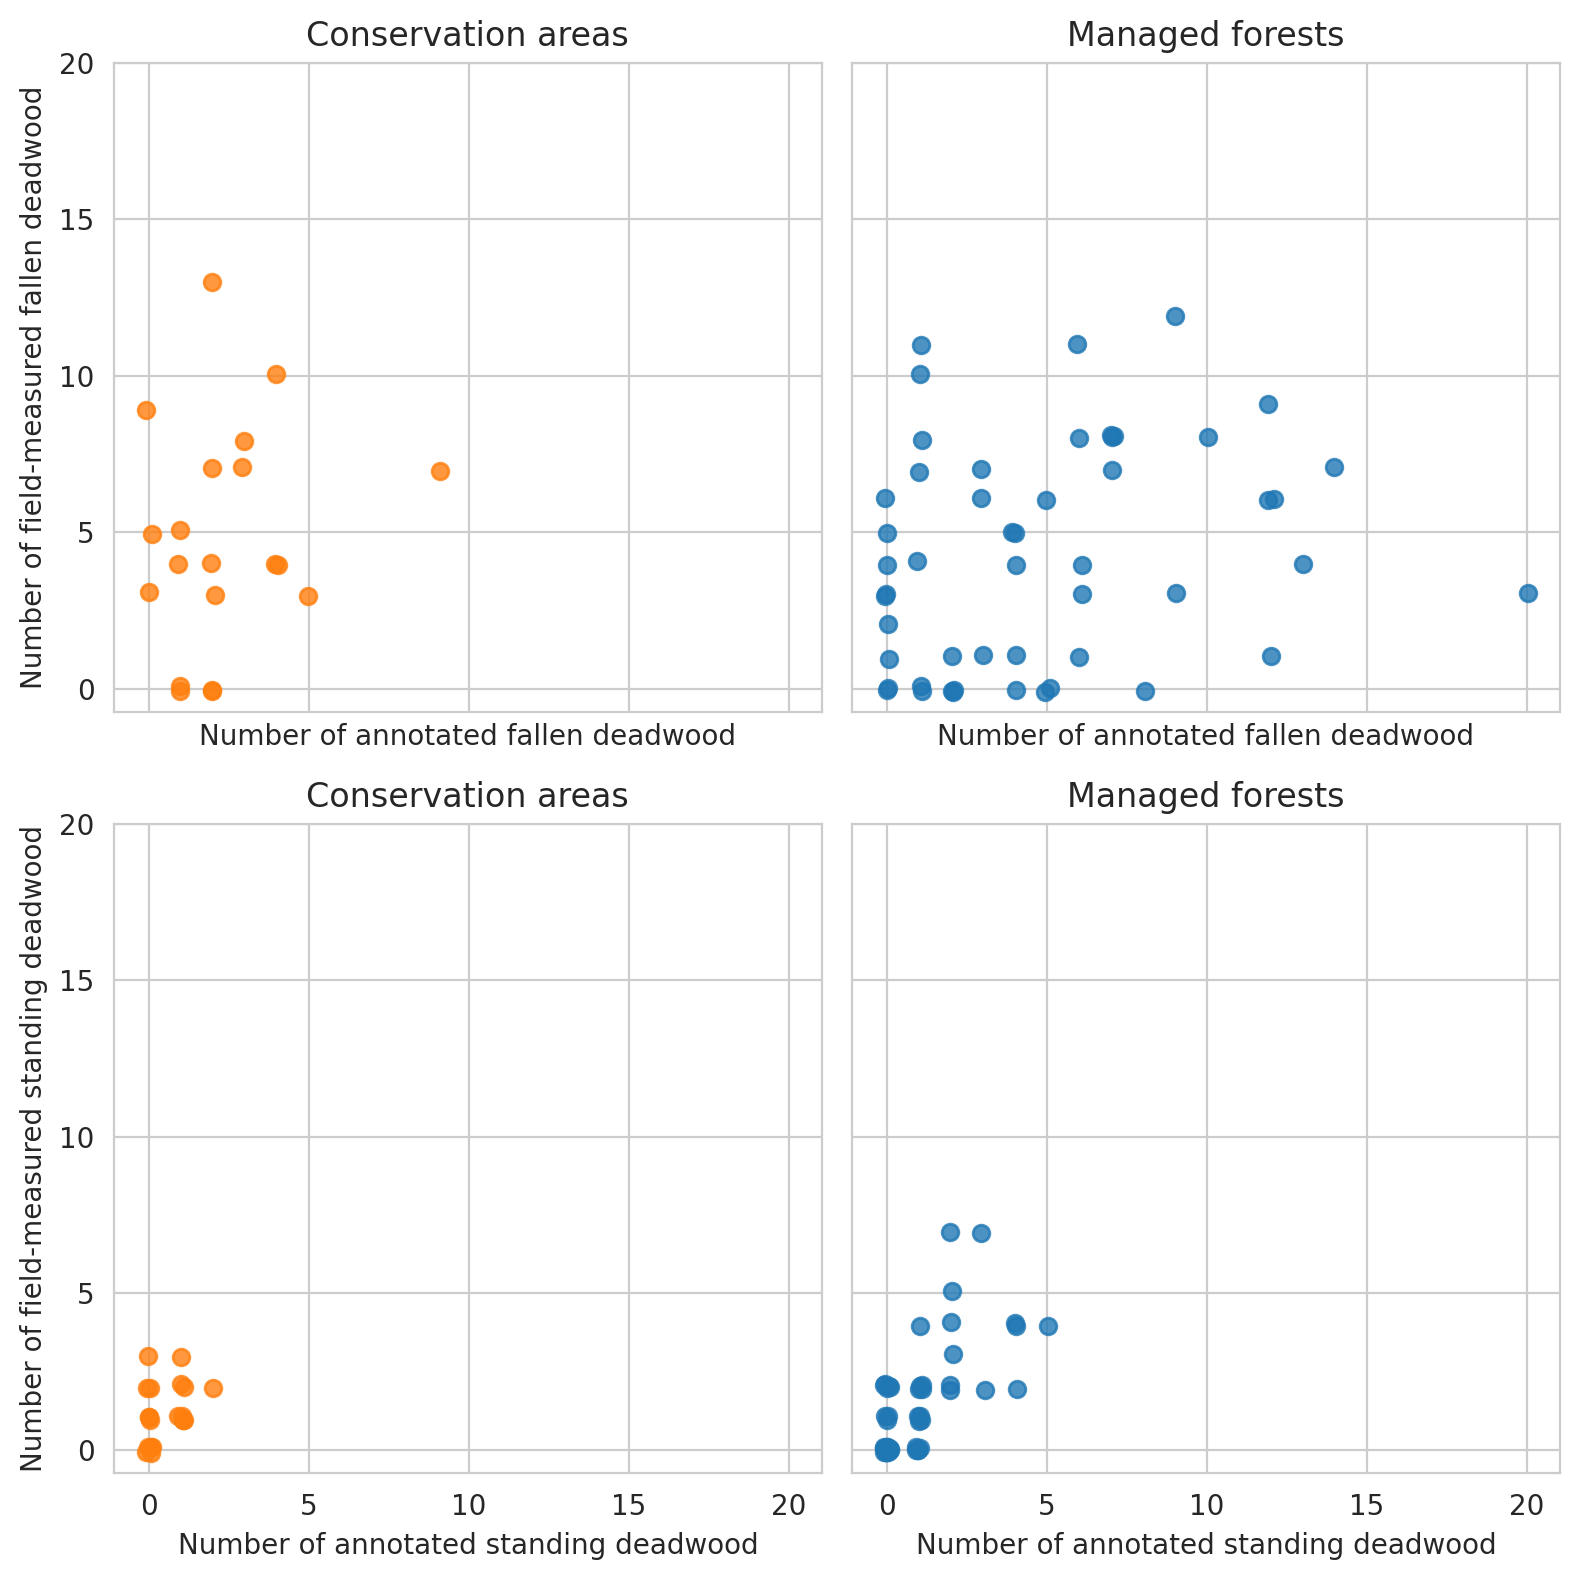

In [ ]:
#| echo: false

fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
sns.regplot(data=plot_dw_data[(plot_dw_data.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
plt.tight_layout()
plt.savefig('../data/figures/hiidenportti_dist.jpeg', dpi=300, bbox_inches='tight')

For annotated groundwood, as the annotations can be twisted due to e.g. orthorectification errors, we use the longest side of the smallest rotated rectangle that can be fit around the polygon as a proxy for the trunk length.

Diameter can be approximated with the following approach. For each polygon,

1. Get minimum rotated rectangle 
2. Draw three lines that are perpendicular to the longer side of the minimum rotated rectangle, starting from the points of 10%, 50% and 90% of the length of the minimum rotated rectangle 
3. Intersect these lines with the polygon. Diameter is the mean lenght of these intersecting lines.

This is not the same as DBH, but close enough.

In [ ]:
anns_in_plots['tree_length'] = anns_in_plots.apply(lambda row: get_len_in_plot(row.geometry, plot_circles), axis=1)

Compare the distributions of the downed trunk lengths. Both graphs only take the parts within the plots into account. Lengths are binned into 1m bins.

As expected, the field measured fallen deadwood were clearly shorter than annotated deadwood. Most of the annotated fallen deadwood were shorter than 2 meters, while field measured trees were typically longer than 5 meters. However, this is most likely due to canopy obscuring the fallen deadwood, and some of the longer trees are annotated as multiple shorter ones. When comparing the difference in total lengths of field-measured trees and annotated trees, typically denser canopy cover meant also larger difference.

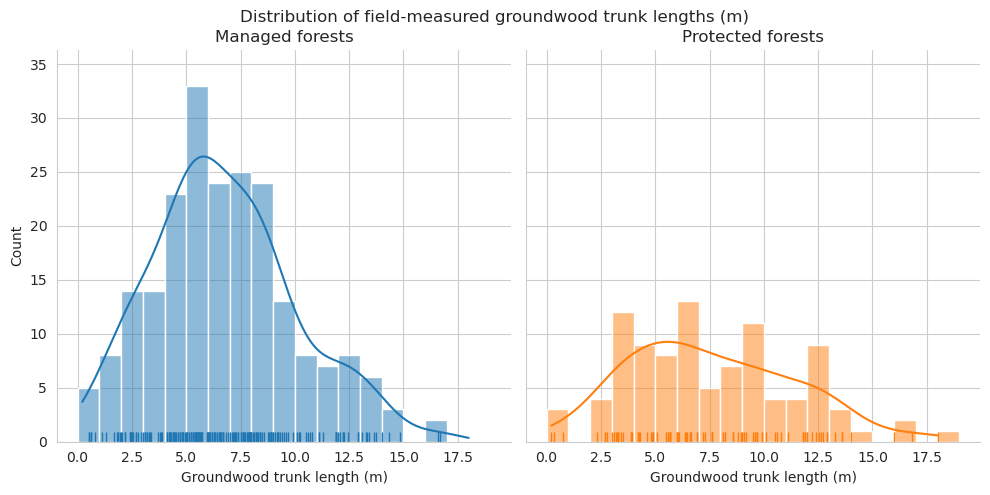

In [ ]:
#| echo: false
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.l > 0)], x='l', 
                hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=1, binrange=(0, max(tree_data[tree_data.tree_class == 4].l))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

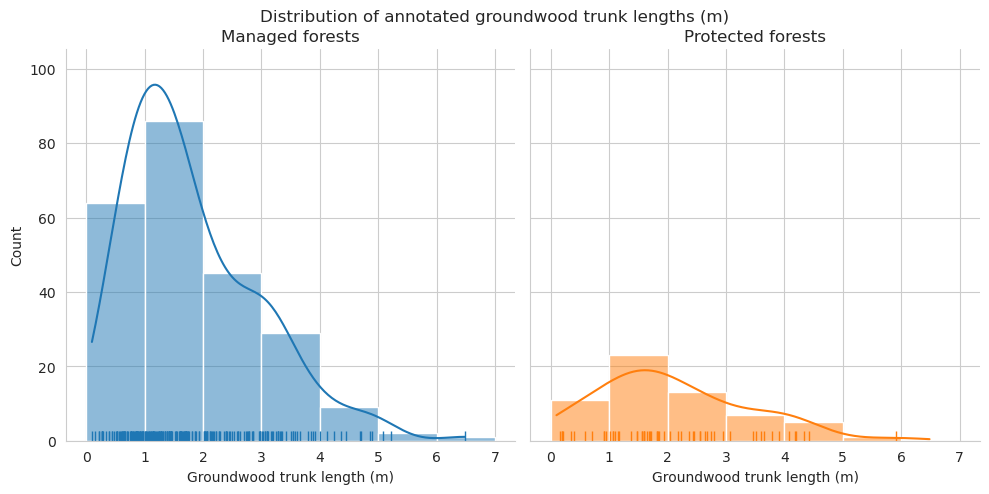

In [ ]:
# | echo: false
g = sns.displot(data=anns_in_plots[anns_in_plots.layer=='groundwood'], x='tree_length',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=1, binrange=(0, max(anns_in_plots.tree_length))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood trunk lengths (m)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk length (m)')
plt.show()

As expected, annotated trunks are clearly on average shorter than field measured.

Compare the measured DBH for downed trees and estimated diameter of annotated downed deadwood. For annotated deadwood, the diameter is estimated for the whole tree, not only for the part within the field plot. DBHs are binned into 50mm bins.

When comparing the DBH distributions for fallen deadwood, the diameter classes 125-150mm, 150-175mm and 175-200mm were clearly overrepresented in the annotated data. As these DBH classes were also the most common among field data, the reason for this could be the same as with length differences, and the visible trees area partially obscured by the canopy.

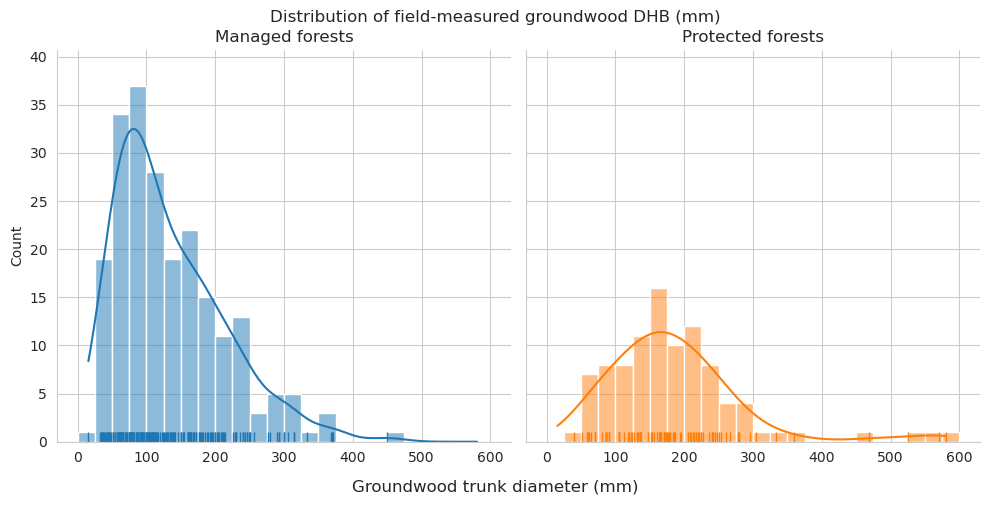

In [ ]:
# | echo: false
g = sns.displot(data=tree_data[(tree_data.tree_class == 4)&(tree_data.DBH>0)], x='DBH', hue='conservation', 
                col='conservation', kde=True, rug=True, legend=False, binwidth=25,
                binrange=(0, max(tree_data[(tree_data.tree_class == 4)].DBH))) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

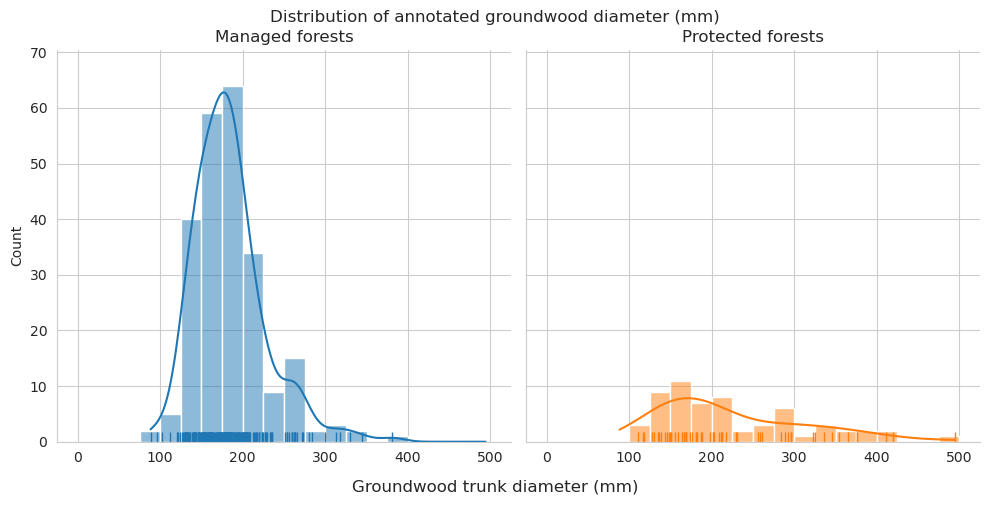

In [ ]:
# | echo: false
anns_in_plots['diam'] = anns_in_plots.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=anns_in_plots[(anns_in_plots.layer=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, 
                binwidth=25, binrange=(0, max(anns_in_plots[(anns_in_plots.layer=='groundwood')].diam)))
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('','')
g.fig.supxlabel('Groundwood trunk diameter (mm)')
plt.show()

Aggregate the above, first field data.

In [ ]:
pd.pivot_table(data=tree_data[(tree_data.tree_class == 4)&(tree_data.DBH>0)],
               index=['conservation'], values=['l', 'DBH'],
               aggfunc=['mean', 'min', 'max', 'count'], margins=True)

mean                  min                   max  \
                     DBH         l        DBH         l         DBH   
conservation                                                          
0             133.786875  6.768601  15.558197  0.518478  450.000000   
1             185.538932  7.588368  39.167120  0.214113  580.560964   
All           149.659711  7.020031  15.558197  0.214113  580.560964   

                        count       
                      l   DBH    l  
conservation                        
0             16.700000   217  217  
1             18.000666    96   96  
All           18.000666   313  313

Then annotations.

In [ ]:
pd.pivot_table(data=anns_in_plots[anns_in_plots.groundwood==2], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max', 'count'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             183.997127    1.818960   88.272337    0.095362  381.292305   
1             224.464449    2.083887  110.641616    0.149797  494.146489   
All           192.199963    1.872662   88.272337    0.095362  494.146489   

                         count              
             tree_length  diam tree_length  
conservation                                
0               6.485503   236         236  
1               5.907329    60          60  
All             6.485503   296         296

Check the relationship between canopy cover and deadwood types. First standing deadwood.

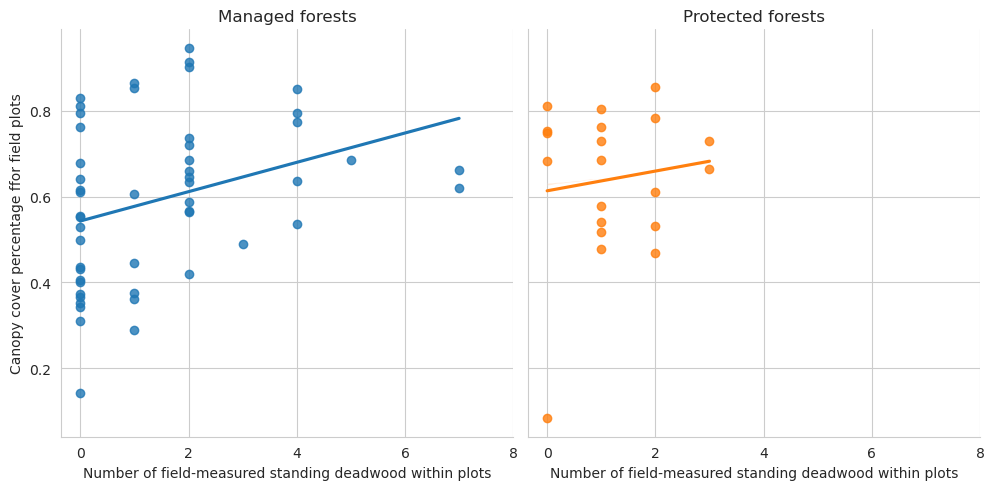

In [ ]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_xticks(range(0,10,2))
g.axes[0,1].set_xticks(range(0,10,2))
g.set_ylabels('Canopy cover percentage ffor field plots')
g.set_xlabels('Number of field-measured standing deadwood within plots')
plt.show()

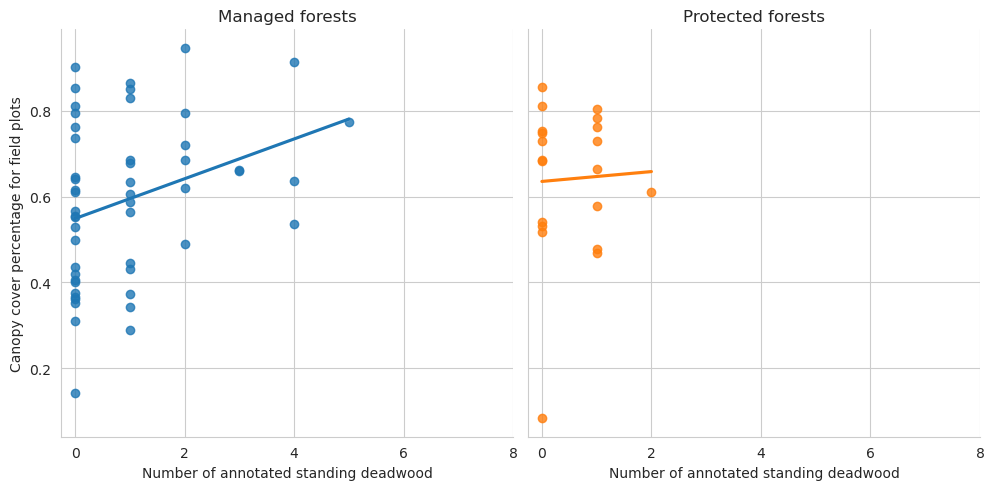

In [ ]:
g = sns.lmplot(data=plot_dw_data, x='n_udw_ann', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_xticks(range(0,10,2))
g.axes[0,1].set_xticks(range(0,10,2))
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of annotated standing deadwood')
plt.show()

Then fallen deadwood

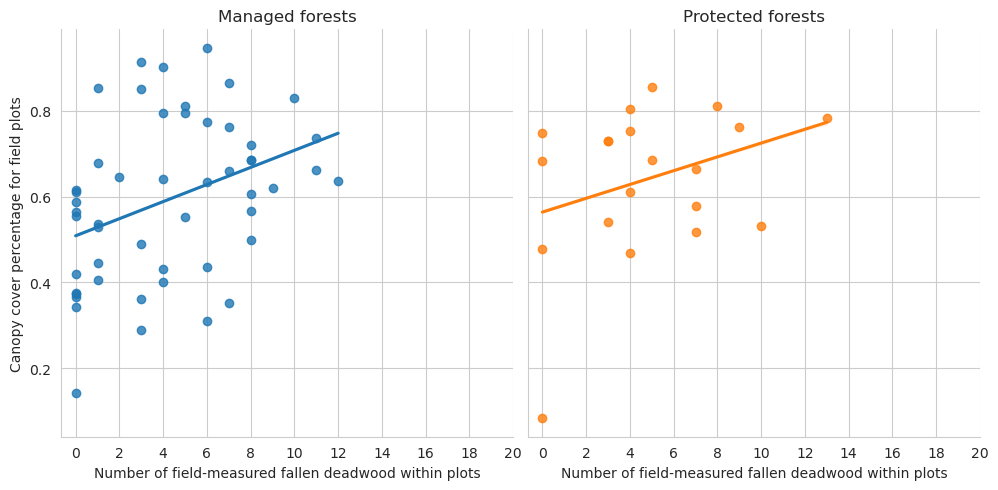

In [ ]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_plot', y='canopy_cover_pct', col='conservation', hue='conservation', ci=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_xticks(range(0,21,2))
g.axes[0,1].set_xticks(range(0,21,2))
g.set_ylabels('Canopy cover percentage for field plots')
g.set_xlabels('Number of field-measured fallen deadwood within plots')
plt.show()

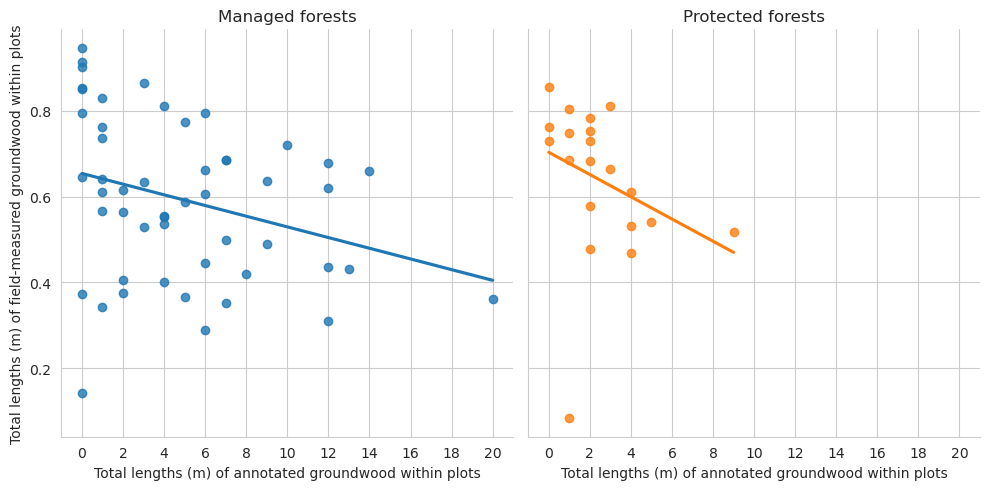

In [ ]:
g = sns.lmplot(data=plot_dw_data, x='n_ddw_ann', y='canopy_cover_pct', col='conservation', hue='conservation',
                legend=False, ci=1)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_xticks(range(0,21,2))
g.axes[0,1].set_xticks(range(0,21,2))
g.set_ylabels('Total lengths (m) of field-measured groundwood within plots')
g.set_xlabels('Total lengths (m) of annotated groundwood within plots')
plt.show()

Plot the total lengths of groundwood located within a single field plot.

In [ ]:
plot_dw_data['n_dw_stand_field'] = plot_dw_data.apply(lambda row: len(tree_data[(tree_data.plot_id == row.id) &
                                                                                (tree_data.tree_class == 3)]),
                                                      axis=1)
plot_dw_data['n_dw_fall_field'] = plot_dw_data.apply(lambda row: len(tree_data[(tree_data.plot_id == row.id) &
                                                                               ((tree_data.tree_class == 4)|
                                                                                (tree_data.tree_class == 5))]),
                                                     axis=1)
plot_dw_data['n_dw_tot_field'] = plot_dw_data.n_dw_stand_field + plot_dw_data.n_dw_fall_field
plot_dw_data['l_gw_field'] = plot_dw_data.apply(lambda row: tree_data[(tree_data.plot_id == row.id) &
                                                                      (tree_data.tree_class == 4)].l.sum()
                                              , axis=1)
plot_dw_data['l_gw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].tree_length.sum()
                                              , axis=1)

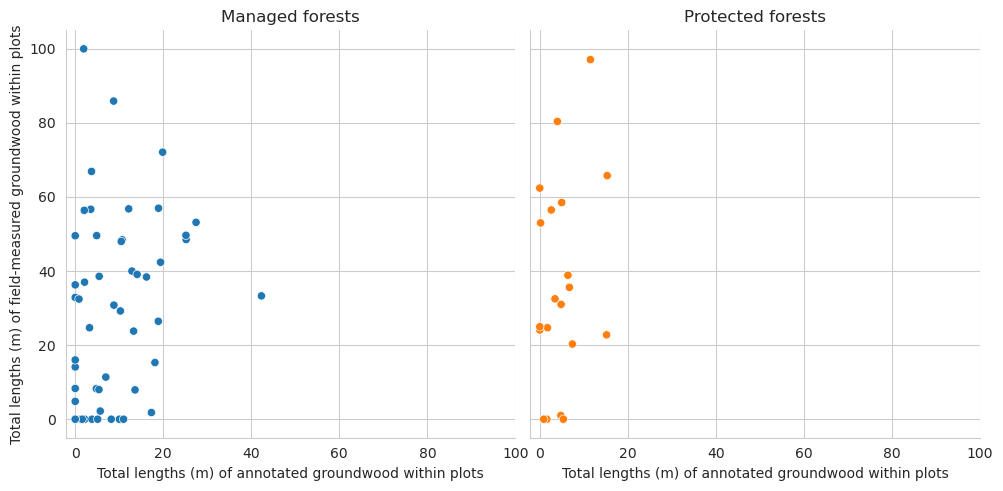

In [ ]:
# | echo: false
g = sns.relplot(data=plot_dw_data, x='l_gw_ann', y='l_ddw', col='conservation', hue='conservation', alpha=1,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,101,20))
g.axes[0,0].set_xticks(range(0,101,20))
g.axes[0,1].set_xticks(range(0,101,20))
g.set_ylabels('Total lengths (m) of field-measured groundwood within plots')
g.set_xlabels('Total lengths (m) of annotated groundwood within plots')
plt.show()

Total lengths for annotations are generally much less than field-measured.

Plot the difference in the numbers of annotated deadwood.

In [ ]:
plot_dw_data['n_ddw_plot_diff'] = plot_dw_data.n_ddw_plot - plot_dw_data.n_ddw_ann
plot_dw_data['n_udw_plot_diff'] = plot_dw_data.n_udw_plot - plot_dw_data.n_udw_ann

Text(0.5, 1.0, 'Conserved forests')

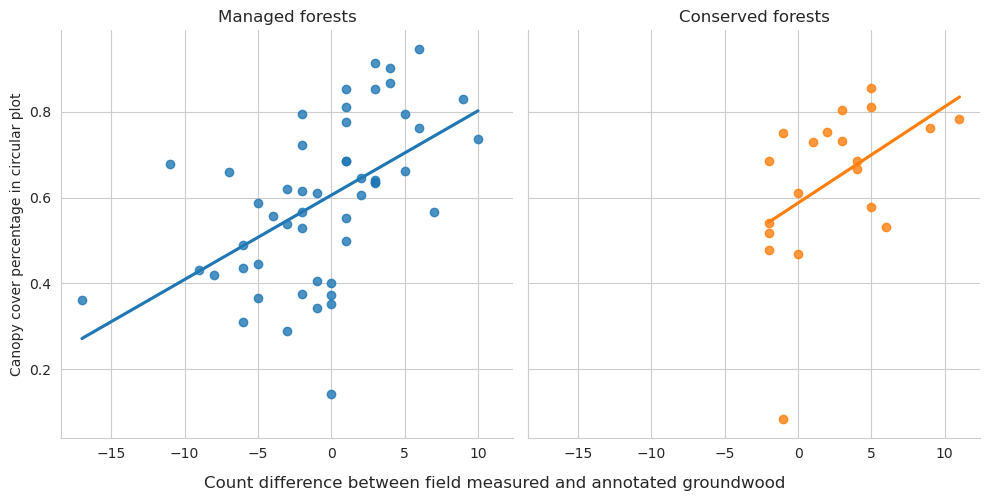

In [ ]:
#| echo: false
g = sns.lmplot(data=plot_dw_data, x='n_ddw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated groundwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

Typically more fallen deadwood is left unannotated if the canopy cover is high.

Text(0.5, 1.0, 'Conserved forests')

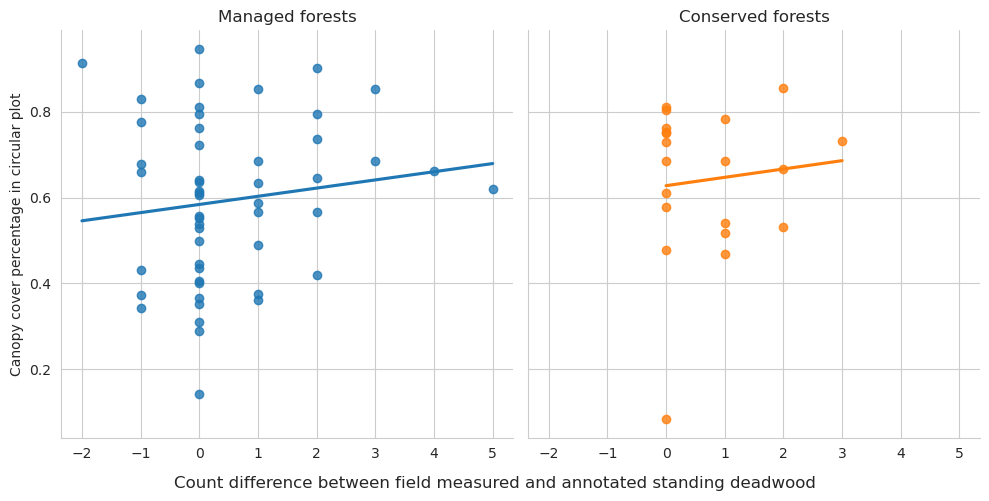

In [ ]:
#| echo: false
g = sns.lmplot(data=plot_dw_data, x='n_udw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Count difference between field measured and annotated standing deadwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][1].set_title('Conserved forests')
#g.map_dataframe(ann, **{'x_col':'n_dw_plot_diff', 'y_col':'canopy_cover_pct'})

For standing deadwood the same effect is not present, at least it can't be seen as clearly.

In [ ]:
plot_dw_data['l_dw_plot_diff'] = plot_dw_data.l_ddw - plot_dw_data.l_gw_ann

Relation between canopy cover percentage and total lengths of groundwood in field plots.

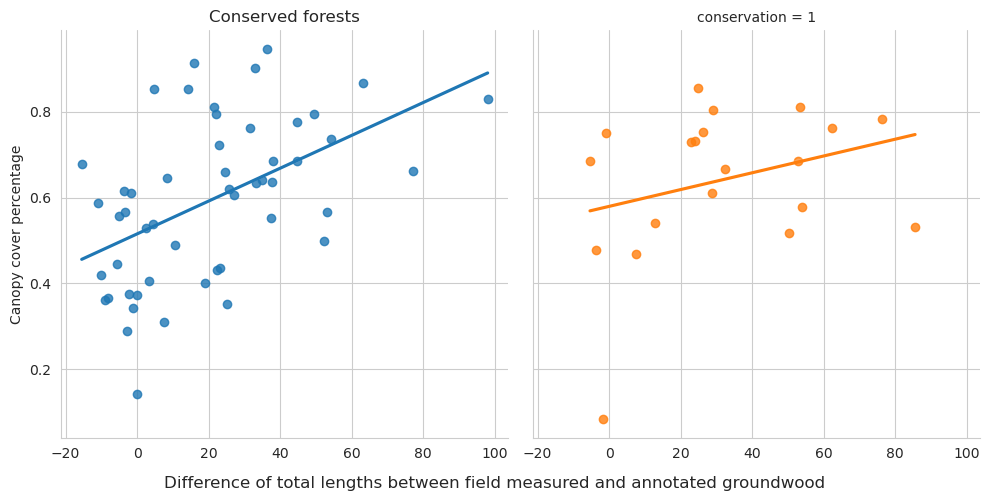

In [ ]:
#| echo: false
g = sns.lmplot(data=plot_dw_data, x='l_dw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage')
g.set_xlabels(' ',' ')
g.fig.supxlabel('Difference of total lengths between field measured and annotated groundwood')
g.axes[0][0].set_title('Managed forests')
g.axes[0][0].set_title('Conserved forests')

plt.show()

Estimate within-plot volume of downed deadwood from annotations.

In [ ]:
anns_in_plots['v_ddw'] = anns_in_plots.geometry.apply(cut_cone_volume)
plot_dw_data['v_ddw_ann'] = plot_dw_data.apply(lambda row: anns_in_plots[(anns_in_plots.plot_id == row.id) &
                                                                        (anns_in_plots.layer == 'groundwood')
                                                                       ].v_ddw.sum()
                                              , axis=1)
plot_dw_data['v_dw_plot'] = (plot_dw_data['v_dw']/10000)*np.pi*9**2
plot_dw_data['v_ddw_plot'] = (plot_dw_data['v_ddw']/10000)*np.pi*9**2
plot_dw_data['v_udw_plot'] = plot_dw_data.v_dw_plot - plot_dw_data.v_ddw_plot

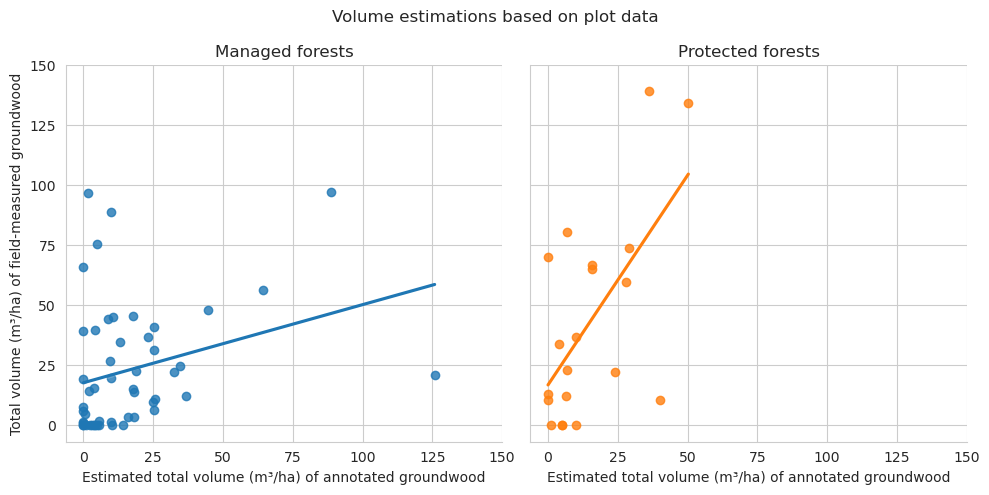

In [ ]:
#| echo: false
plot_dw_data['v_ddw_ann_ha'] = (10000 * plot_dw_data.v_ddw_ann) / (np.pi * 9**2)
g = sns.lmplot(data=plot_dw_data, x='v_ddw_ann_ha', y='v_ddw', col='conservation', hue='conservation', ci=0,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,151,25))
g.axes[0,0].set_xticks(range(0,151,25))
g.axes[0,1].set_xticks(range(0,151,25))
g.set_ylabels('Total volume (m³/ha) of field-measured groundwood')
g.set_xlabels('Estimated total volume (m³/ha) of annotated groundwood')
plt.suptitle('Volume estimations based on plot data')
plt.tight_layout()
plt.show()

Compare statistics for the total volume of fallen deadwood. First field data.

In [ ]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,0.0,97.300652,22.922567,14.343594,26.380391,51
1,0.0,139.171786,42.482418,28.313861,42.481488,20
All,0.0,139.171786,28.432385,15.575737,32.641219,71


Then estimation based on annotations.

In [ ]:
pd.pivot_table(data=plot_dw_data, index=['conservation'], values=['v_ddw_ann_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha
conservation,,,,,,
0,0.0,125.818406,16.205743,9.736776,23.196205,51
1,0.0,50.287535,14.730784,8.459501,14.889016,20
All,0.0,125.818406,15.790261,9.736776,21.093812,71


Plot the difference between volume based on field data and estimated volume based on annotations.

<seaborn.axisgrid.FacetGrid>

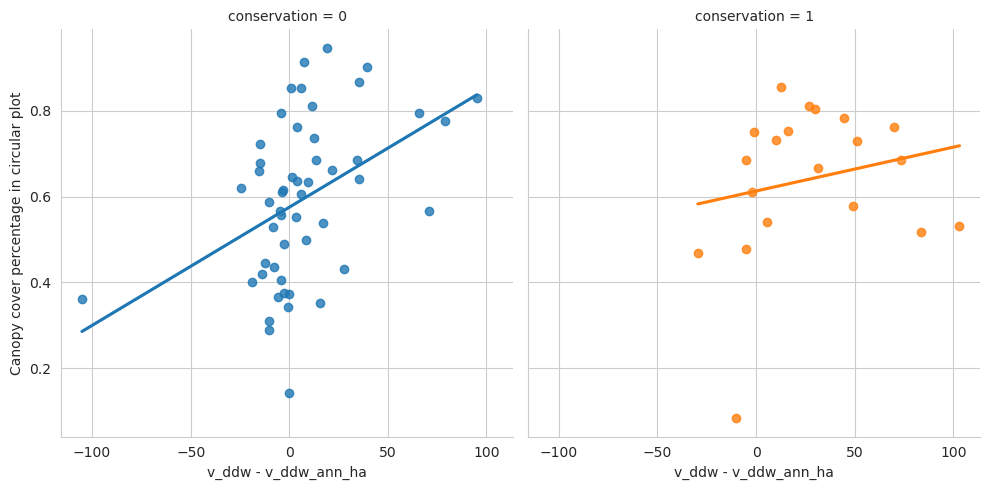

In [ ]:
#| echo: false
plot_dw_data['v_ddw_diff'] = plot_dw_data.v_ddw - plot_dw_data.v_ddw_ann_ha
g = sns.lmplot(data=plot_dw_data, x='v_ddw_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('v_ddw - v_ddw_ann_ha')


Again, denser canopy means generally more difference.

## Sudenpesänkangas

Read data and do some wrangling. 

In [ ]:
evo_fd_path = Path('../data/sudenpesankangas/')
evo_anns = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')
evo_anns = evo_anns.to_crs('epsg:3067')
evo_plot_circles = gpd.read_file(evo_fd_path/'plot_circles.geojson')
evo_plot_circles['id'] = evo_plot_circles['id'].astype(int)

evo_field_data = pd.read_csv(evo_fd_path/'puutiedot_sudenpesänkangas.csv', sep=';', decimal=',')
evo_field_data = gpd.GeoDataFrame(evo_field_data, geometry=gpd.points_from_xy(evo_field_data.gx, evo_field_data.gy), 
                                   crs='epsg:3067')
evo_grid = gpd.read_file(evo_fd_path/'vplots.geojson')
evo_grid = evo_grid.to_crs('epsg:3067')
evo_field_data['plotid'] = evo_field_data.kaid + 1000
evo_field_data = evo_field_data[evo_field_data.puuluo.isin([3,4])]

cons_evo = conservation_areas[conservation_areas.geometry.intersects(box(*evo_anns.total_bounds))]
cons_evo = gpd.clip(cons_evo, evo_grid)

def match_plotid_spk(geom, plots):
    for r in plots.itertuples():
        if r.geometry.contains(geom):
            return r.id
    return None

evo_plots_updated = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018.txt', sep=' ')
evo_plots_luke = pd.read_csv(evo_fd_path/'Koealatunnukset_Evo_2018_LUKE.txt', sep=' ')
evo_plots_updated = gpd.GeoDataFrame(evo_plots_updated, geometry=gpd.points_from_xy(evo_plots_updated.x,
                                                                                    evo_plots_updated.y),
                                     crs='epsg:3067')
evo_plots_luke = gpd.GeoDataFrame(evo_plots_luke, geometry=gpd.points_from_xy(evo_plots_luke.x,
                                                                              evo_plots_luke.y),
                                     crs='epsg:3067')
evo_plots = pd.concat([evo_plots_updated, evo_plots_luke])
evo_plots.rename(columns= {c: c.replace('.','_') for c in evo_plots.columns}, inplace=True)

evo_plots['spk_id'] = evo_plots.geometry.apply(lambda row: match_plotid_spk(row, evo_plot_circles))

evo_plots.dropna(subset='spk_id', inplace=True)

evo_plots['geometry'] = evo_plots.spk_id.apply(lambda row: evo_plot_circles[evo_plot_circles.id == row].geometry.iloc[0])

evo_plots.drop(columns=['id'], inplace=True)
evo_plots.rename(columns={'spk_id': 'id'}, inplace=True)

evo_plots['conservation'] = evo_plots.geometry.apply(lambda row: 1 if cons_evo.geometry.unary_union.intersects(row)
                                                     else 0)

evo_anns['plot_id'] = evo_anns.apply(lambda row: int(row.vplot_id.split('_')[1]), axis=1)

evo_plots = evo_plots[evo_plots.id.isin(evo_anns.plot_id.unique())]

evo_anns['plot_id'] = evo_anns.apply(lambda row: match_circular_plot(row, evo_plots), axis=1)
evo_anns = evo_anns[evo_anns.geometry.intersects(evo_plots.geometry.unary_union)].copy()

Add canopy density based on LiDAR derived canopy height model. The density is the percentage of field plot area with height above 2 meters.

In [ ]:
pcts = []

with rio.open('../../data/raw/sudenpesankangas/full_mosaics/sudenpesankangas_chm.tif') as src:
    for row in evo_plots.itertuples():
        plot_im, plot_tfm = rio_mask.mask(src, [row.geometry], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])
        
evo_plots['canopy_cover_pct'] = pcts

pd.pivot_table(data=evo_plots, index=['conservation'], values=['canopy_cover_pct'],
               aggfunc=['min', 'max', 'mean', 'std', 'count'], margins=True)

,min,max,mean,std,count
,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct,canopy_cover_pct
conservation,,,,,
0,0.237288,0.989960,0.782452,0.200439,42
1,0.678000,0.991992,0.869878,0.085901,29
All,0.237288,0.991992,0.818162,0.168393,71


As seen here, canopies in Evo are far more dense than in Hiidenportti.

Count the number of deadwood instances similarly as for Hiidenportti data and plot the relationship between them.

In [ ]:
evo_plots['n_dw_ann'] = evo_plots.apply(lambda row: evo_anns.plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns.plot_id.unique() else 0, axis=1)
evo_plots['n_ddw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label=='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label=='groundwood'].plot_id.unique() else 0, axis=1)
evo_plots['n_udw_ann'] = evo_plots.apply(lambda row: evo_anns[evo_anns.label!='groundwood'].plot_id.value_counts()[int(row.id)]
                                        if row.id in evo_anns[evo_anns.label!='groundwood'].plot_id.unique() else 0, axis=1)

evo_plots['n_dw_plot'] = np.round((evo_plots['n_dw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_ddw_plot'] = np.round((evo_plots['n_ddw']/10000)*np.pi*9**2).astype(int)
evo_plots['n_udw_plot'] = evo_plots.n_dw_plot - evo_plots.n_ddw_plot
evo_plots['conservation'] = evo_plots.apply(lambda row: 1 if any(cons_evo.geometry.contains(row.geometry))
                                                        else 0, axis=1)

evo_plots.pivot_table(index='conservation', values=['n_ddw_plot', 'n_udw_plot', 'n_ddw_ann', 'n_udw_ann'], 
                         aggfunc='sum', margins=True)

,n_ddw_ann,n_ddw_plot,n_udw_ann,n_udw_plot
conservation,,,,
0,65,14,14,68
1,22,29,29,92
All,87,43,43,160


For Evo dataset, we were able to annotate twice as much groundwood as there are in total in the field data, and only a quarter of the number of standing deadwood. Because Evo dataset is missing the field-measured information for deadwood height, we were not able to check whether the missing standing deadwood were, for instance, only a couple of meters tall and thus hidden below the canopy. Compared to Hiidenportti, the forest canopy in Evo was significantly thicker, as the average canopy cover percentage in the field plots was around 82%. 

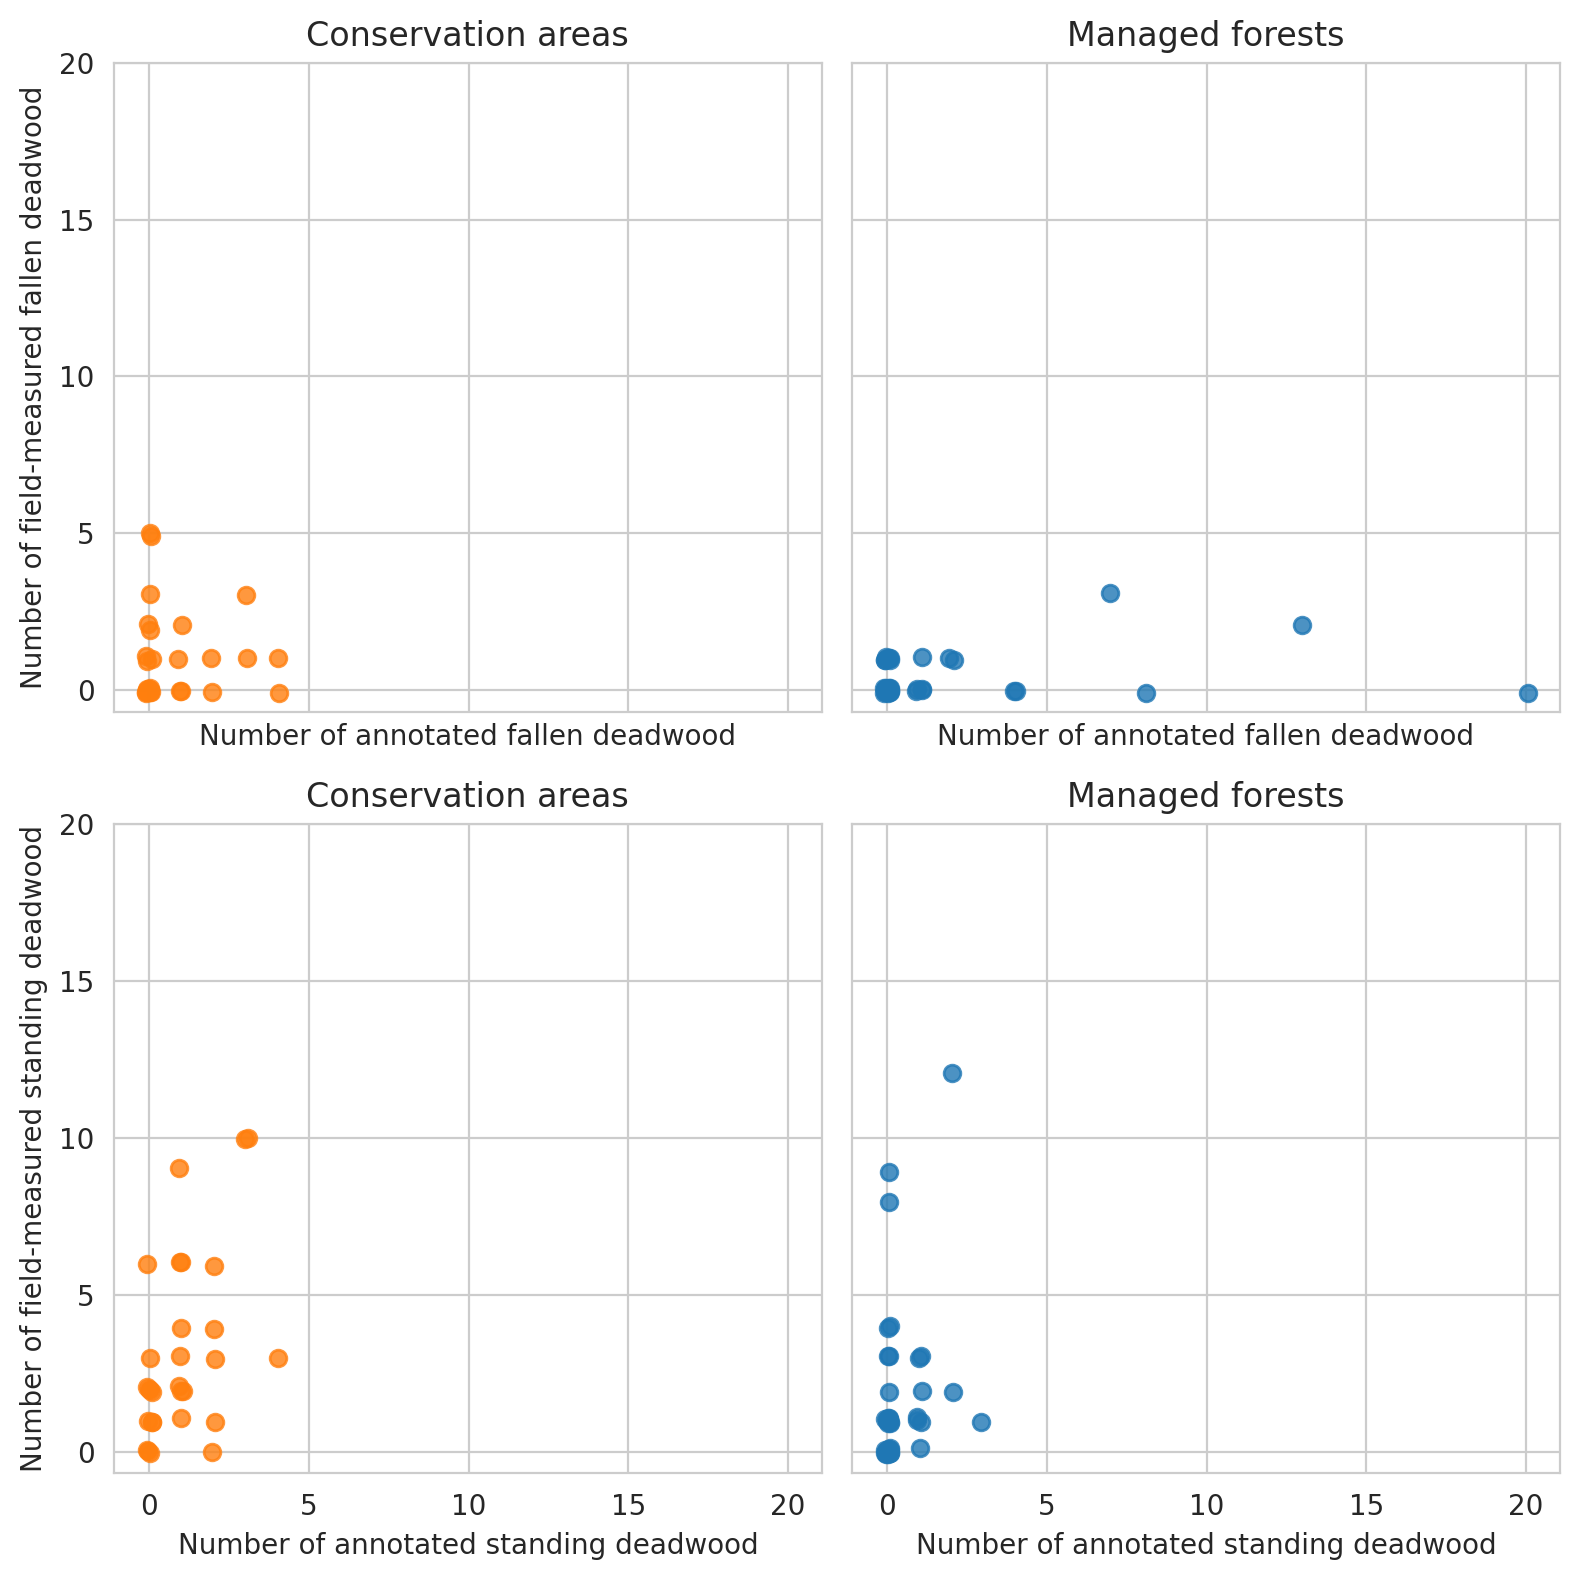

In [ ]:
#| echo: false

fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=200, sharey=True, sharex=True)
sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[0,0].set_title('Conservation areas')
ax[0,0].set_yticks(range(0,21,5))
ax[0,0].set_yticklabels(range(0,21,5))
ax[0,0].set_xlabel('Number of annotated fallen deadwood')
ax[0,0].set_ylabel('Number of field-measured fallen deadwood')
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_ddw_ann', y='n_ddw_plot', ax=ax[0,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[0,1].set_title('Managed forests')
ax[0,1].set_yticks(range(0,21,5))
ax[0,1].set_yticklabels(range(0,21,5))
ax[0,1].set_xlabel('Number of annotated fallen deadwood')
ax[0,1].set_ylabel('')


sns.regplot(data=evo_plots[(evo_plots.conservation == 1)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,0], 
            color='tab:orange', x_jitter=0.1, y_jitter=0.1)
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Number of annotated standing deadwood')
ax[1,0].set_ylabel('Number of field-measured standing deadwood')
ax[1,0].set_yticks(range(0,21,5))
ax[1,0].set_yticklabels(range(0,21,5))
sns.regplot(data=evo_plots[(evo_plots.conservation == 0)], fit_reg=False, 
            x='n_udw_ann', y='n_udw_plot', ax=ax[1,1], 
            color='tab:blue', x_jitter=0.1, y_jitter=0.1)
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Number of annotated standing deadwood')
ax[1,1].set_ylabel('')
ax[1,1].set_yticks(range(0,21,5))
ax[1,1].set_yticklabels(range(0,21,5))
plt.tight_layout()
plt.savefig('../data/figures/evo_dist.jpeg', dpi=300, bbox_inches='tight')

Plot the plot-wise differences between field-measurements and annotations.

<seaborn.axisgrid.FacetGrid>

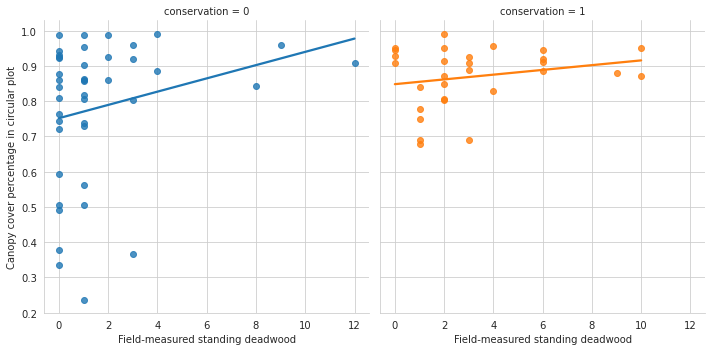

In [ ]:
g = sns.lmplot(data=evo_plots, x='n_udw_plot', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('Field-measured standing deadwood')
plt.show()

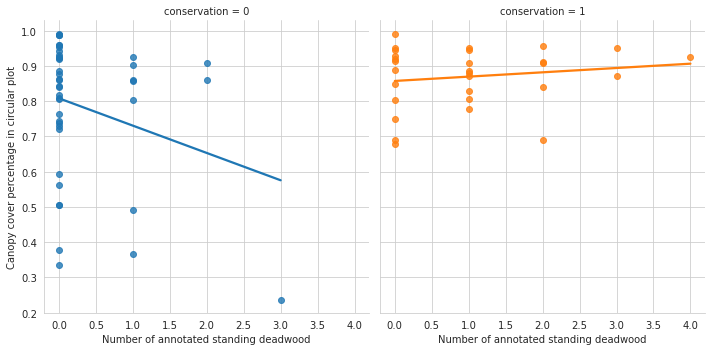

In [ ]:
g = sns.lmplot(data=evo_plots, x='n_udw_ann', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('Number of annotated standing deadwood')
plt.show()

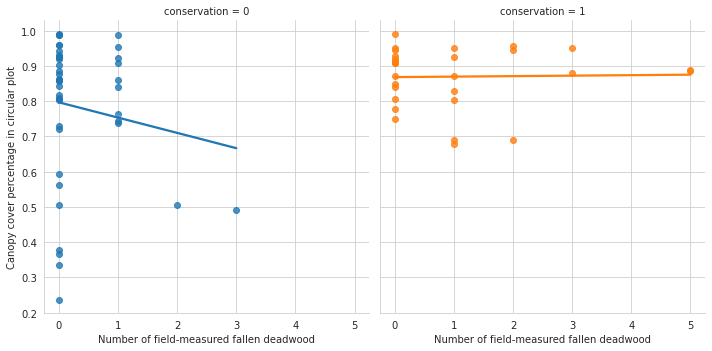

In [ ]:
g = sns.lmplot(data=evo_plots, x='n_ddw_plot', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('Number of field-measured fallen deadwood')
plt.show()

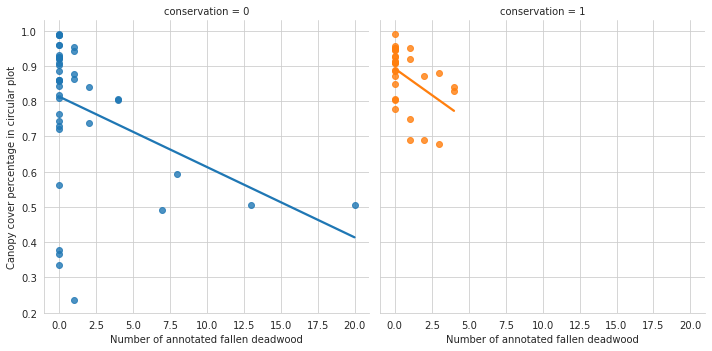

In [ ]:
g = sns.lmplot(data=evo_plots, x='n_ddw_ann', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('Number of annotated fallen deadwood')
plt.show()

Again, denser canopy indicates less annotated fallen data.

Same plots but for differences in numbers.

In [ ]:
evo_plots['n_ddw_diff'] = evo_plots.n_ddw_plot - evo_plots.n_ddw_ann
evo_plots['n_udw_diff'] = evo_plots.n_udw_plot - evo_plots.n_udw_ann

First for fallen deadwood.

<seaborn.axisgrid.FacetGrid>

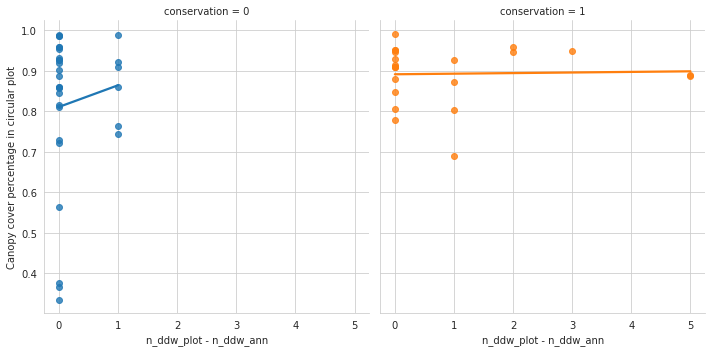

In [ ]:
#| echo: false
g = sns.lmplot(data=evo_plots[evo_plots.n_ddw_diff >=0], x='n_ddw_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('n_ddw_plot - n_ddw_ann')

Then for standing deadwood.

<seaborn.axisgrid.FacetGrid>

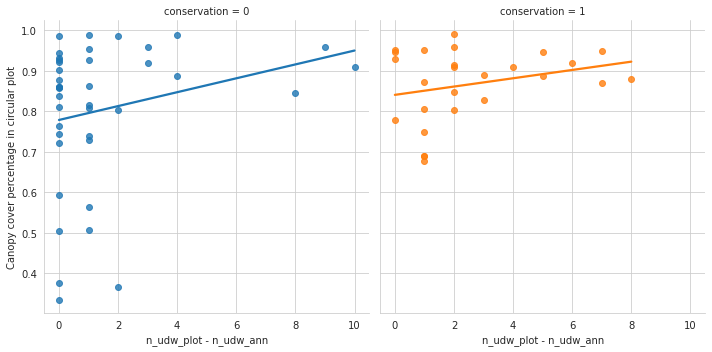

In [ ]:
#| echo: false
g = sns.lmplot(data=evo_plots[evo_plots.n_udw_diff >=0], x='n_udw_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('n_udw_plot - n_udw_ann')


See whether there is any realotion between the number of annotated fallen deadwood an canopy cover.

<seaborn.axisgrid.FacetGrid>

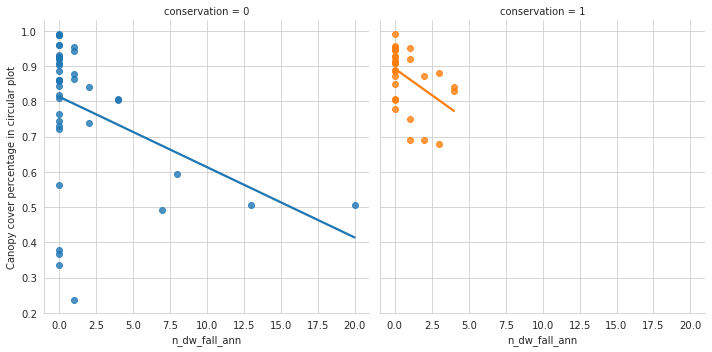

In [ ]:
#| echo: false
g = sns.lmplot(data=evo_plots, x='n_ddw_ann', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('n_dw_fall_ann')


Or the difference between the number of annotations (positive means more field data than annotated data) and canopy cover.

In [ ]:
evo_plots['n_dw_plot_diff'] = evo_plots.n_dw_plot - evo_plots.n_dw_ann

<seaborn.axisgrid.FacetGrid>

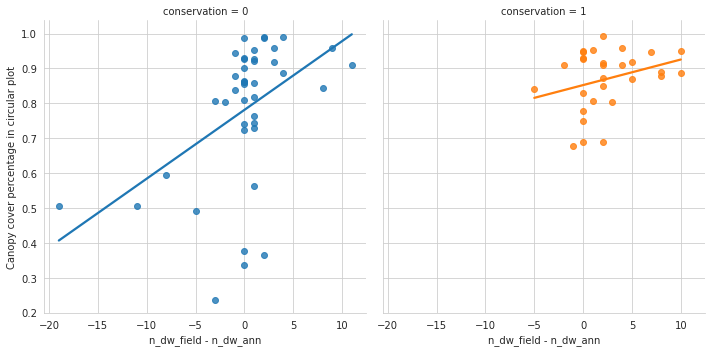

In [ ]:
#| echo: false
g = sns.lmplot(data=evo_plots, x='n_dw_plot_diff', y='canopy_cover_pct', col='conservation',
               hue='conservation', ci=0)
g.set_ylabels('Canopy cover percentage in circular plot')
g.set_xlabels('n_dw_field - n_dw_ann')


Again, denser canopy indicates less annotated groundwood, and here also deadwood in general. However, Evo has such a low number of fallen deadwood that evaluating that is difficult.

As Evo data doesn't have field-measured deadwood lengths, we can't plot that relationship. We can, however, plot the DBH distributions, even though Evo dataset only has 43 downed deadwood with dbh measured.

In [ ]:
evo_field_data = evo_field_data[evo_field_data.plotid.isin(evo_plots.id.unique())]
evo_field_data['conservation'] = evo_field_data.apply(lambda row: evo_plots[evo_plots.id == row.plotid].conservation.unique()[0], axis=1)

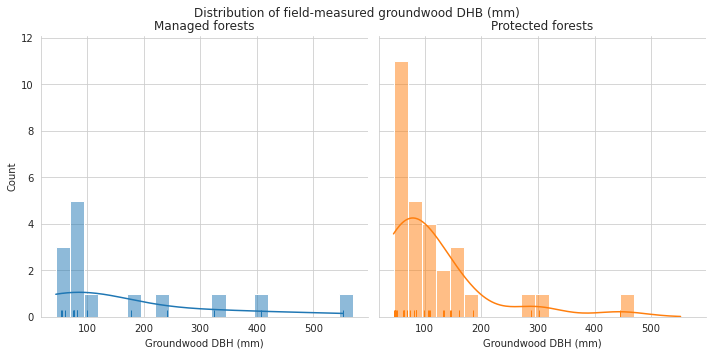

In [ ]:
#| echo: false
g = sns.displot(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)], 
                x='lapimitta_mm', hue='conservation', col='conservation'
                ,kde=True, rug=True, legend=False, binwidth=25) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of field-measured groundwood DHB (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood DBH (mm)')
plt.show()

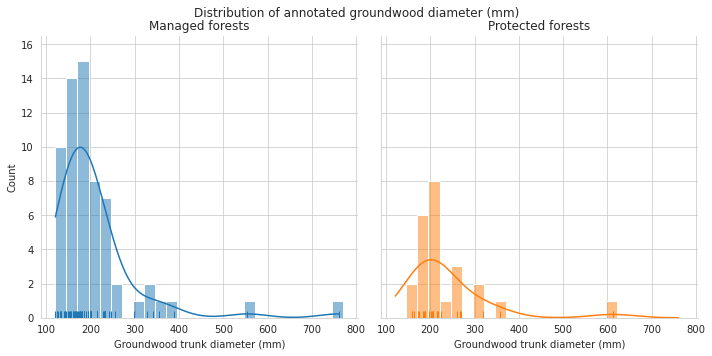

In [ ]:
#| echo: false

evo_anns['diam'] = evo_anns.geometry.apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
g = sns.displot(data=evo_anns[(evo_anns.label=='groundwood')], x='diam',
                kde=True, rug=True, col='conservation', hue='conservation', legend=False, binwidth=25) 
g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Distribution of annotated groundwood diameter (mm)')
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.set_xlabels('Groundwood trunk diameter (mm)')
plt.show()

Some statistics for field data.

In [ ]:
pd.pivot_table(data=evo_field_data[(evo_field_data.puuluo == 4)&(evo_field_data.lapimitta_mm>0)],
               index=['conservation'], values=['est_pituus_m', 'lapimitta_mm'],
               aggfunc=['mean', 'min', 'max', 'count'], margins=True)

mean                       min                       max  \
             est_pituus_m lapimitta_mm est_pituus_m lapimitta_mm est_pituus_m   
conservation                                                                    
0               13.609571   169.357143        5.934           55       34.211   
1               11.905690   115.896552        5.446           45       28.101   
All             12.460442   133.302326        5.446           45       34.211   

                                 count               
             lapimitta_mm est_pituus_m lapimitta_mm  
conservation                                         
0                     552           14           14  
1                     445           29           29  
All                   552           43           43

Same for annotated data.

In [ ]:
evo_anns['tree_length'] = evo_anns.geometry.apply(get_len)
pd.pivot_table(data=evo_anns[evo_anns.label=='groundwood'], index=['conservation'], values=['tree_length', 'diam'],
               aggfunc=['mean', 'min', 'max', 'count'], margins=True)

mean                     min                     max  \
                    diam tree_length        diam tree_length        diam   
conservation                                                               
0             208.385386    3.272615  120.871980    0.605847  760.781151   
1             237.667882    4.457594  157.761173    1.164928  612.397653   
All           216.463316    3.599506  120.871980    0.605847  760.781151   

                         count              
             tree_length  diam tree_length  
conservation                                
0              13.146859    63          63  
1              17.731423    24          24  
All            17.731423    87          87

Volume estimations for Evo data are really inaccurate, as most field data measurements are zero.

In [ ]:
evo_anns['v_ddw'] = evo_anns.geometry.apply(cut_cone_volume)
evo_plots['v_ddw_ann'] = evo_plots.apply(lambda row: evo_anns[(evo_anns.plot_id == row.id) &
                                                              (evo_anns.label == 'groundwood')
                                                              ].v_ddw.sum()
                                              , axis=1)

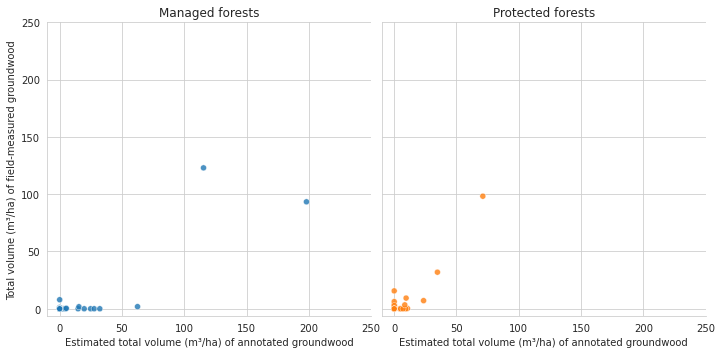

In [ ]:
#| echo: false
evo_plots['v_ddw_ann_ha'] = (10000 * evo_plots.v_ddw_ann) / (np.pi * 9**2)
g = sns.relplot(data=evo_plots, x='v_ddw_ann_ha', y='v_ddw', col='conservation', hue='conservation', alpha=.8,
                legend=False)
g.axes[0,0].set_title('Managed forests')
g.axes[0,1].set_title('Protected forests')
g.axes[0,0].set_yticks(range(0,251,50))
g.axes[0,0].set_xticks(range(0,251,50))
g.axes[0,1].set_xticks(range(0,251,50))
g.set_ylabels('Total volume (m³/ha) of field-measured groundwood')
g.set_xlabels('Estimated total volume (m³/ha) of annotated groundwood')
plt.show()

Statistics for volume based on annotations.

In [ ]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw,v_ddw
conservation,,,,,,
0,0.0,123.004587,5.522673,0.0,23.497052,42
1,0.0,98.258093,6.338610,0.0,18.873961,29
All,0.0,123.004587,5.855943,0.0,21.587804,71


In [ ]:
pd.pivot_table(data=evo_plots, index=['conservation'], values=['v_ddw_ann_ha'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

,min,max,mean,median,std,count
,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha,v_ddw_ann_ha
conservation,,,,,,
0,0.0,198.137000,12.501564,0.0,36.044690,42
1,0.0,71.154407,6.350595,0.0,14.777089,29
All,0.0,198.137000,9.989196,0.0,29.284613,71
